In [1]:
%matplotlib inline
import seaborn as sns, pandas as pd, numpy as np, os, qiime2 as q2, skbio as sb
from matplotlib.pylab import plt

load_mf = lambda x: q2.Metadata.load(x).to_dataframe()

from biom import Table
from skbio.stats.ordination import pcoa, pcoa_biplot
from emperor import nbinstall, Emperor
from scipy.spatial.distance import euclidean

nbinstall()

In [2]:
cd trimmed-150nts/

/Users/yoshikivazquezbaeza/Documents/PDF/KnightLaboratory/HastyWater/trimmed-150nts


In [3]:
mf = load_mf('mapping-file.alpha.tsv')

dm = q2.Artifact.load('unweighted.unifrac.dm.qza').view(sb.DistanceMatrix)

table = q2.Artifact.load('feature-table.even.18813.normalized.qza').view(pd.DataFrame)
table = table.divide(table.sum(axis=1), 'rows')

taxonomy = q2.Artifact.load('taxonomy.qza').view(pd.DataFrame)

In [4]:
def from_frame(row):
    ret = row.Taxon.split(';')
    ret = ret + ([''] * (7 - len(ret))) 
    
    return pd.Series(ret, index=['kingdom', 'phylum', 'class', 'order', 'family', 'genus', 'species'])

feature_mf = taxonomy.apply(from_frame, axis=1)

In [5]:
res = pcoa_biplot(pcoa(dm), table)

In [6]:
features = res.features.copy()
features['importance'] = features.apply(lambda x: euclidean(np.zeros_like(x), x), axis=1)
features.sort_values('importance', inplace=True, ascending=False)
features.drop(['importance'], inplace=True, axis=1)

res.features = features[:20].copy()

In [7]:
Emperor(res, mf, feature_mf, remote=False)

From the plot above you can see three groups of arrows, one pointing to the left, the other to the top and the final to the right. Let's pick a representative of each of these three groups (at random) and see them in a line plot below.

In [8]:
matrix = table
matrix['day'] = mf['day'].copy()
matrix['Description'] = mf['Description'].copy()
matrix.sort_values(by='day', inplace=True)

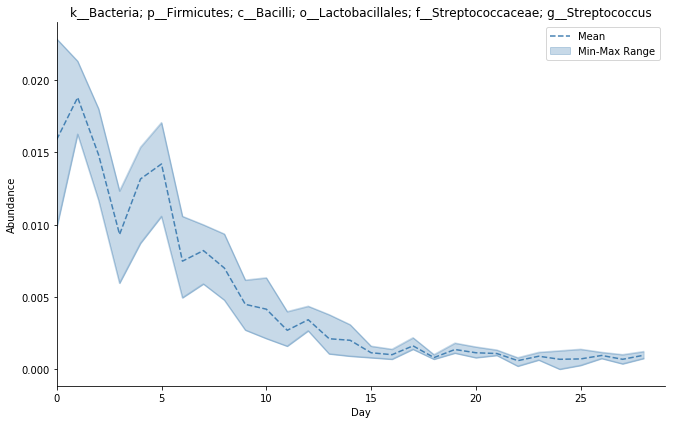

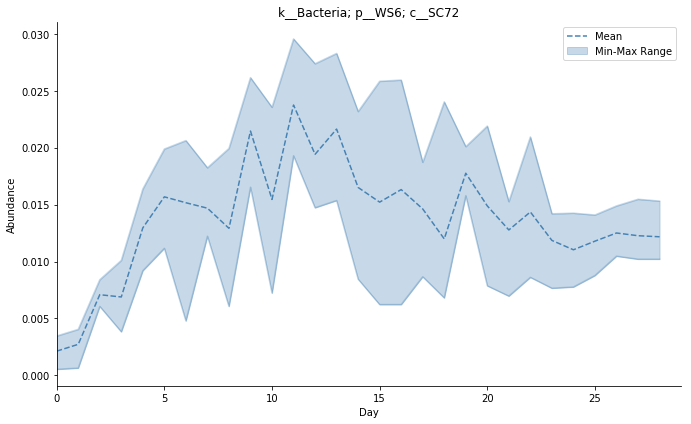

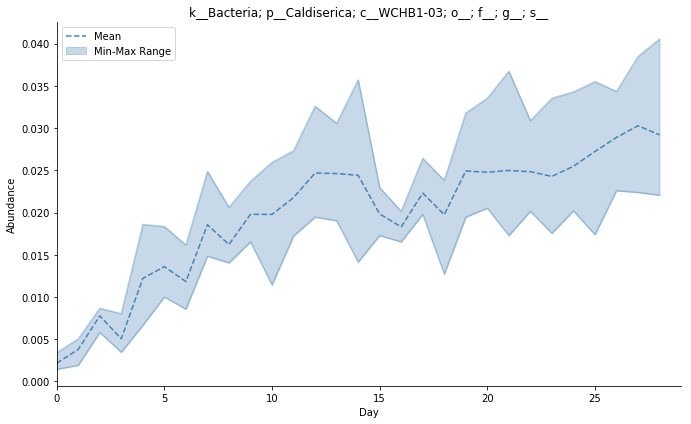

In [21]:
!mkdir -p individual-time-series

sequences = [
    ('Bacilli', 'CCTACGGGGGGCAGCAGTAGGGAATCTTCGGCAATGGGGGGAACCCTGACCGAGCAACGCCGCGTGAGTGAAGAAGGTTTTCGGATCGTAAAGCTCTGTTGTAAGAGAAGAACGTGTGTGAGAGTGGAAAGTTCACACAGTGACGGTAAC'),
    ('SC72', 'CCTACGGGGGGCAGCAATTAGGAATCTTGCGCAATGGGGGCAACCCTGACGCAGCGACACAGCGTGGAGGATGAAGGTCTTCGGATTGTAAACTCCTTTTATATGGGAAGAATAGATGACTGTACCATATGAATAAGTACCTGCTAACTA'),
    ('WCB1-03', 'CCTACGGGGGGCAGCAGTGGGGAATCATGGTCAATGGGCGAAAGCCTGAACCTGCGACGCCGCGTGAGTGATGAAGGTCGTAAGATCGTAAAACTCTTTTCAGGGATCTTAAAGCCTGTCTGTCAACAACAGGCAGGTCTGACTCTCCCT')
]

days = np.arange(0, 29)

for klass, tax in sequences:
    fig = plt.figure()
    plt.title(taxonomy.loc[tax].Taxon)
    
    # set after the title so figure sizes are the same
    fig.set_figheight(6)
    fig.set_figwidth(6 * 1.6180)

    mean = []

    for i in range(4):
        sub = matrix[matrix.Description == 'Digester%d' % (i + 1)]
        mean.append(sub[tax].values)

    plt.plot(days, np.mean(mean, axis=0), 'SteelBlue', linestyle='dashed', label='Mean')
    
    plt.fill_between(days, np.min(mean, axis=0), np.max(mean, axis=0), alpha=0.3,
                     color='SteelBlue', label='Min-Max Range')

    plt.plot(days, np.min(mean, axis=0), 'SteelBlue', alpha=0.3)
    plt.plot(days, np.max(mean, axis=0), 'SteelBlue', alpha=0.3)

    plt.legend()
    plt.xlabel('Day')
    plt.ylabel('Abundance')
    plt.xlim(0, 29)

    sns.despine()
    
    plt.tight_layout()
    
    plt.savefig('individual-time-series/' + klass + '.svg')